In [192]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.stats import rankdata
from scipy.stats import kendalltau
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pvlib
from copulas.bivariate import Frank


In [185]:
#importation des données
raw_df=pd.read_csv(r"C:\Users\Vincent Barbera\Desktop\Data.csv",sep=';',index_col=[0],parse_dates=[0])

original_entries=raw_df.shape[0]

#caractéristique du site
latitude=-21+(20/60)
longitude=55+(29/60)
elevation=75

#ajout des données de positions solaire
solar_position=pvlib.solarposition.get_solarposition(time=pd.date_range(start='2021-01-01 00:00:00', end='2022-12-30 04:10:00',freq=('10T'),tz='Indian/Reunion'),latitude=latitude,longitude=longitude,altitude=elevation)

raw_df=pd.merge(raw_df,solar_position,how='left', on=raw_df.index)



C:\Users\Vincent Barbera\AppData\Local\Temp\ipykernel_35760\2654793772.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  solar_position=pvlib.solarposition.get_solarposition(time=pd.date_range(start='2021-01-01 00:00:00', end='2022-12-30 04:10:00',freq=('10T'),tz='Indian/Reunion'),latitude=latitude,longitude=longitude,altitude=elevation)


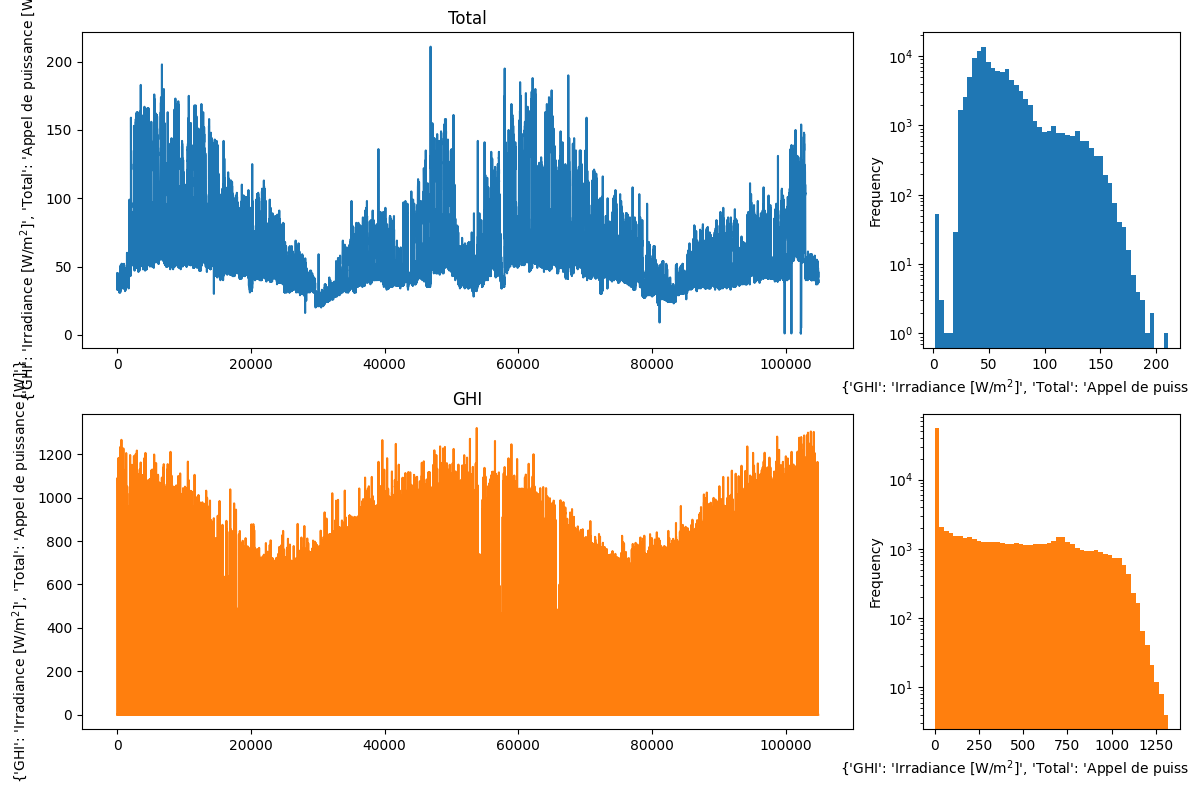

In [186]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), gridspec_kw={'width_ratios':[3,1]})

ylabel_dict = {
    'GHI' :'Irradiance [W/m$^2$]',
    'Total' :'Appel de puissance [W]'
}

for i, c in enumerate(['Total','GHI']):
    raw_df[c].plot(ax=axes[i,0], c='C{}'.format(i), title=c)
    raw_df[c].plot.hist(ax=axes[i,1], logy=True, bins=50, facecolor='C{}'.format(i))
    axes[i,0].set_xlabel('')
    axes[i,0].set_ylabel(ylabel_dict)
    axes[i,1].set_xlabel(ylabel_dict)
fig.tight_layout()

Préparation des datas

In [187]:

#suppresion des valeurs où la hauteur solaire est inférieur à 10°
df=raw_df.where(raw_df["elevation"]>10)

#Suppression des valeurs manquantes
df=df[~np.isnan(df).any(axis=1)]

#normalisation des données
maxGHI, minGHI = np.max(df["GHI"]),np.min(df["GHI"])
maxLOAD, minLOAD = np.max(df["Total"]),np.min(df["Total"])
GHI=(df["GHI"]-maxGHI)/(minGHI-maxGHI)
LOAD=(df["Total"]-maxLOAD)/(minLOAD-maxLOAD)

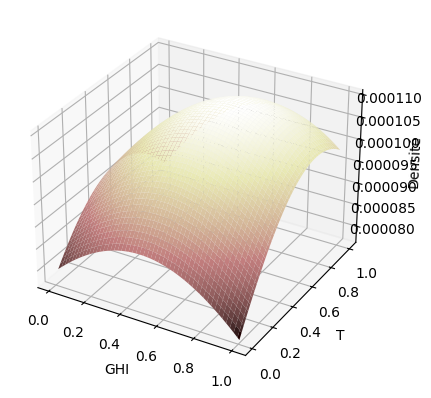

In [188]:
#Copule Gaussienne
maillage=100

C=np.column_stack((GHI,LOAD))
covar_matrix=np.corrcoef(C,rowvar=False)
centre=[np.mean(GHI),np.mean(LOAD)]

x1, x2=np.linspace(0.01,1,100),np.linspace(0.01,1,100)
X1,X2=np.meshgrid(x1,x2)
X=np.column_stack((X1.flatten(),X2.flatten()))

y=multivariate_normal.pdf(X,mean=centre,cov=covar_matrix)

copule=np.zeros((maillage,maillage))
for i in range(100):
    for j in range(100):
        copule[i,j]=y[i*100+j]

copule=copule/np.sum(copule)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, copule.reshape(100, 100), cmap='pink')
ax.set_xlabel('GHI')
ax.set_ylabel('T')
ax.set_zlabel('Densité')
plt.show()


c:\Users\Vincent Barbera\AppData\Local\Programs\Python\Python313\Lib\site-packages\copulas\bivariate\base.py:163: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn('Data does not appear to be uniform.', category=RuntimeWarning)


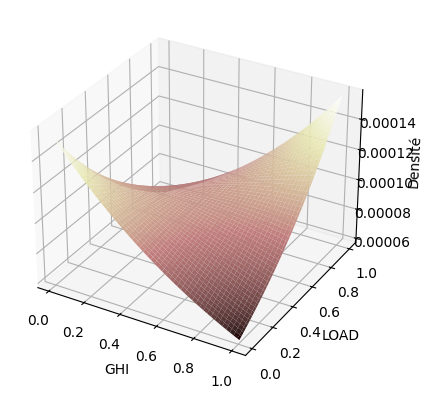

In [189]:
#Copule de Frank
maillage=100

C=np.column_stack((GHI,LOAD))
correlation, _=kendalltau(GHI,LOAD)
frank=Frank()
frank.fit(C)

x1 = np.linspace(0.01, 1, maillage)
x2 = np.linspace(0.01, 1, maillage)
X1, X2 = np.meshgrid(x1, x2)
X = np.column_stack((X1.ravel(), X2.ravel()))

y = frank.probability_density(X)

copule= np.zeros((maillage, maillage))
for i in range(100):
    for j in range(100):
        copule[i, j] = y[i * 100 + j]

copule /= np.sum(copule)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, copule.reshape(100, 100), cmap='pink')
ax.set_xlabel('GHI')
ax.set_ylabel('LOAD')
ax.set_zlabel('Densité')
plt.show()

done9%
done18%
done27%
done36%
done45%
done55%
done64%
done73%
done82%
done91%
done100%


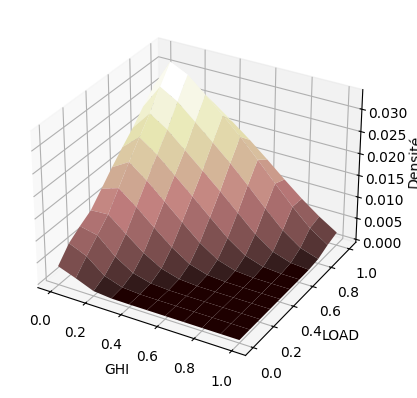

In [ ]:
#copule empirique
maillage=11

sigma=1
copule = np.zeros((maillage, maillage))

for i in range (1, maillage+1):
    for j in range (1, maillage+1):
        for k in range(len(GHI)):
            if (i-1)/maillage <= GHI[k] < i/maillage and (j-1)/maillage <= LOAD[k] < i/maillage:
                for m in range (i-maillage, i+maillage+1):
                    for n in range(j-maillage,j+maillage+1):
                        if 1 <= m <= maillage and 1 <= n <= maillage:
                            copule[m-1,n-1] += np.exp(-(((m-i)/maillage*10)**2+((n-j)/maillage*10)**2)/sigma**2)
    print(f'done{round(i/maillage*100)}%')

copule /=np.sum(copule)

fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
X, Y = np.meshgrid(np.linspace(0,1,maillage),np.linspace(0,1,maillage))
ax.plot_surface(X,Y,copule, cmap='pink', edgecolor='none')
ax.set_xlabel('GHI')
ax.set_ylabel('LOAD')
ax.set_zlabel('Densité')
plt.show()